# Задание 2: Трехклассовая семантическая сегментация

## DL курс на ВМК. Осень 2025

Дата выдачи: <span style="color:red">__17 октября 21:00__</span>.

Дедлайн: <span style="color:red">__4 ноября 22:00__</span>.

Стоимость: __60 баллов__.

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

Предлагается решить задачу семантической сегментации животных с тремя классами: класс "фон" (метка 0), класс "кошка" (метка 1) и класс "собака" (метка 2).
![Image](https://miro.medium.com/max/1130/1*DDEkOFC93pEbrTdyhdpXZg.png)

Для этого сами подготовим [датасет](https://drive.google.com/uc?export=download&id=1ZsRAXiPgOU5Am8tNZ7mruwtJh3ck8TI5), реализуем метрики/функции потерь, реализуем и обучим свою [PSPNet](https://arxiv.org/abs/1612.01105)-подобную архитектуру.

In [9]:
# скачиваем данные
!gdown -q --id 1ZsRAXiPgOU5Am8tNZ7mruwtJh3ck8TI5 -O data.zip
!unzip -qq data.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1ZsRAXiPgOU5Am8tNZ7mruwtJh3ck8TI5

but Gdown can't. Please check connections and permissions.
unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!unzip -qq SegTask.zip

replace __MACOSX/._SegTask? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
#!rm -f data.zip

### Загрузка модулей

In [13]:
# Загружаем pytorch для работы с нейронными сетями
import torch
import torch.nn as nn
import torch.nn.functional as F

# Для работы с изображениями/графиками
from torchvision import transforms
# Загружаем способы интерполяции изображений
from torchvision.transforms.functional import InterpolationMode as IM
import matplotlib.pyplot as plt

# Для логирования метрик и функций потерь в ходе обучения
from torch.utils.tensorboard import SummaryWriter

# Для удобной работы с обучающей/тестовой выборкой
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Прочее
import numpy as np
from tqdm.notebook import tqdm

## Часть 1: Подготовка данных

### 1.1 Предобработка датасета (5 баллов)

Для начала работы с данными требуется выполнить следующие пункты:
- **Определиться со способом хранения/чтения данных с диска. Предлагается сравнить три варианта: `HDF5`, `memory-mapped files` и `"сырой"` вид ( хранение `.jpg/.png` файлов на диске). Все необходимые классы уже описаны в файле `utils.py`. Предлагается лишь замерить скорость чтения данных для каждого из форматов, затем выбрать наиболее быстрый.**
    - Поговорим поподробнее об особенностях этих форматов хранения. В задачах комьютерного зрения датасеты, как правило, имеют большой размер, который не помещается в оперативную память.  Формат `hdf5` позволяет разбивать массивы информации на [chunks](https://www.oreilly.com/library/view/python-and-hdf5/9781491944981/ch04.html), которые организованы в виде [B-деревьев](https://en.wikipedia.org/wiki/B-tree). Такой вид хранения необходим для эффективного чтения `hyperslabs` - многомерных срезов массива, которые несмежны в памяти (non-contiguous). По умолчанию, `hdf5` хранит данные непрерывно (contiguous)
    - `Memory-mapping` файлов в оперативную память позволяет пропустить этап буфферизации, тем самым пропуская операцию копирования, лениво загружая информацию напрямую. Особенность этого подхода в том, что алгоритмически `Best case` скорости чтения достигается на непрерывном блоке информации (contiguous), а `Worst case` - наоборот, на несмежном в памяти (non-contiguous) блоке (на порядки хуже, чем потенциально возможно в `hdf5`).

- **Привести все пары (изображение, маска) к единому размеру `target_shape`, указанному далее в словаре конфигурации `default_config`**. Предлагается следующая последовательность действий:
    1. **При помощи [transforms.Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) интерполировать (по умолчанию билинейная интерполяция) значения пикселей при изменении размера исходного изображения до заданного**. Однако, подобная операция искажает исходное соотношение сторон изображения, что может негативно сказаться на предсказательной способности сети. Например, общий вид морды кошки будет зависеть от исходного размера изображения, а не от сущности класса "кошка": оно может быть не растянуто, может быть растянуто вертикально/горизонтально. Неконсистентность в представлении одной и той же сущности может привести к нестабильному обучению, так как размеры ядра свертки едины для любого входного изображения! К счастью, эта проблема уже решена в `transforms.Resize`: при целочисленном аргументе `size` наименьшая сторона входного изображения будет интерполирована до `size`, а другая сторона (наибольшая) до размера `size * aspect_ratio`, т.е сохраняя соотношение сторон `aspect_ratio`
    2. На текущий момент лишь одна из сторон исходного изображения соответствует требуемому размеру `target_shape`. Возможен случай когда оставшаяся сторона больше требуемого размера. Тогда необходимо **обрезать изображение при помощи [transforms.CenterCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.CenterCrop.html#torchvision.transforms.CenterCrop)**.

> Последовательное исполнение операций модуля `transforms` можно выполнить при помощи [transforms.Compose](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html).
- **Ответить на вопрос:** `А зачем, вообще, требуется сводить все изображения к одному размеру?`

**Ваш ответ:** потому что сети работают с входными данными фиксированных размерностей и ожидают фиксированного количества входов

In [14]:
from utils import *

def resize(img: Image_t, target_shape: tuple[int, int]) -> np.array:
    """
    Приводит входное изображение (или маску) `img` к размеру `target_shape`, указанной выше
    последовательностью действий. Предполагается, что требуемый размер `target_shape` "квадратный"
    """
    # Проверяем равенство желаемых ширины и высоты в target_shape
    assert target_shape[0] == target_shape[1]

    # Масштабируем наименьшую размерность `img` под `target_shape`
    # В качестве способа интерполяции выберем интерполяцию методом ближайшего соседа
    # Это необходимо для сохранения множества значений маски сегментации
    # используйте transforms.Resize
    #YOUR CODE
    resize_transform = transforms.Compose([
        transforms.Resize(target_shape[0], interpolation=IM.NEAREST),
        transforms.CenterCrop(target_shape),
        transforms.Lambda(lambda img: np.array(img))
        ])
        # Преобразуем PIL.Image изображение в массив np.array
 # используйте transforms.Lambda


    return resize_transform(img)

In [15]:
def prepare_dataset(config: dict, storage_class: Type[storage_class]):
    """
    Предобрабатывает датасет и эффективно его сохраняет на диск
    """
    with open(config["annotation_file"]) as f:
        lines = f.readlines()

    # Заводим массивы для блоков изображений, помещаемых в память
    input_chunk = np.empty((config["chunk_size"], *config["target_shape"], 3), dtype=np.uint8)
    target_chunk = np.empty((config["chunk_size"], *config["target_shape"]), dtype=np.uint8)

    # Делим датасет на блоки
    config["dataset_size"] = len(lines)
    num_chunks = config["dataset_size"] // config["chunk_size"] + bool(config["dataset_size"] % config["chunk_size"])
    dataset = storage_class(config)

    # Читаем изображения с диска, предобрабатываем и сохраняем в выбранный нами формат
    for chunk_idx in tqdm(range(num_chunks)):
        for pos in range(config["chunk_size"]):
            flat_idx = chunk_idx * config["chunk_size"] + pos
            if (flat_idx >= config["dataset_size"]):
                break

            img_name, label = lines[flat_idx].rstrip("\n").split(' ')

            input_raw = Image.open(os.path.join(config["input_dir"], img_name + ".jpg")).convert("RGB")
            target_raw = Image.open(os.path.join(config["target_dir"], img_name + ".png")).convert('L')

            input_chunk[pos] = resize(input_raw, config["target_shape"])
            target_chunk[pos] = renumerate_target(resize(target_raw, config["target_shape"]), int(label))
        dataset.append(input_chunk, target_chunk)
    dataset.lock()

    return dataset


Для простоты будем выбирать размер изображений `target_shape` с одинаковыми сторонами. Предлагается использовать размер `256x256`, хотя выбор за вами. Обратите внимание, что от размера изображений зависит быстродействие дальнейшего кода (чем больше картинки, тем дольше обучать).

In [16]:
# если хотите перезапустить ячейку, возможно вам понадобится удалить некоторые файлы, раскоменьте строчку ниже
#!rm -rf SegTask/trainval.h5 SegTask/trainval

# Конфигурация датасета
default_config = {
             "input_dir": "SegTask/images",
             "target_dir": "SegTask/seg_masks",
             "target_shape": (256, 256), # Можно любой другой размер картинки
             "chunk_size": 512, # количество изображений в блоке, загружаемых в оперативную память
            }

# Конфигурации обучающей и тестовой выборок отличаются файлов аннотации
config_train = {"annotation_file":  "SegTask/trainval.txt"} | default_config
config_test = {"annotation_file": "SegTask/test.txt"} | default_config

train_data_hdf5 = prepare_dataset(config_train, storage_hdf5)
train_data_memmap = prepare_dataset(config_train, storage_memmap)
train_data_raw = prepare_dataset(config_train, storage_raw)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

### 1.2 Создание Dataset и DataLoader (6 баллов)

Pytorch [предоставляет](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) нам удобные обертки Dataset и DataLoader для наших данных, которые эффективно нарезают наш датасет на `batches` (блоки) заданного размера, а также параллелизуют процесс чтения на `num_workers` нитей.

Также для дальнейшей работы нам понадобится [аугментация](https://pytorch.org/vision/stable/transforms.html) данных. Ее цель заключается в еще большем расширении обучающей выборки путем применения преобразований над изображениями, которые изменяют их абсолютные значения пикселей, но не нарушают их информационное наполнение.

Например, преобразование [ColorJitter](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter) способно изменить яркость изображения на случайное число, что не изменяет его контекст. Однако, преобразование  [RandomCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomCrop.html#torchvision.transforms.RandomCrop) не рекомендуется, посколько есть шанс, что мордочка животного не попадет в фото и класс животного будет неоднозначен. Таким образом, при каждом вызове объекта из обучающей выборки к нему будет применяться случайное преобразование/серия случайных преобразований. **Обратите внимание, что преобразование изображения должно быть согласованным с его сегментационной маской**.

**Требуется реализовать предлагаемые ниже преобразования аугментации:**
- `HorizontalFlip` (1.5 балла)
- `ColorJitter` (1.5 балла)
- `RandomPerspective` (2 балла)

Для каждого из указанных преобразований требуется написать магический метод `__call__`, который позволяет обращаться к объекту класса (преобразованию), как к функции (функтор из C++):
```Python
# инициализация
obj = Example()
# вызывается __call__
obj()
```

In [17]:
# Предлагается использовать эти функции
# Самому писать процедуры отражения картинки по вертикали/горизонтали или цветокоррекции не надо!
from torchvision.transforms.functional import hflip
from torchvision.transforms.functional import perspective
from torchvision.transforms import ColorJitter as CJ


class HorizontalFlip():
    def __init__(self, prob: float):
        self.p = prob

    def __call__(self, pair: tuple[Image_t, Image_t]) -> tuple[Image_t, Image_t]:
        """
        `pair` содержит пару (изображение, сегментационная маска)
        * Почитайте: https://pytorch.org/vision/main/generated/torchvision.transforms.functional.hflip.html
        """
        if (np.random.binomial(1, self.p)):
            pair = (hflip(pair[0]), hflip(pair[1]))
        return pair


class ColorJitter():
    def __init__(self, prob: float, param: tuple[float, ...]):
        self.p = prob
        self.CJ = CJ(*param)

    def __call__(self, pair: tuple[Image_t, Image_t]) -> tuple[Image_t, Image_t]:
        """
        `pair` содержит пару (изображение, сегментационная маска)
        * Почитайте: https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html
        * Сделайте по аналогии с HorizontalFlip
        """
        #YOUR CODE
        if(np.random.binomial(1, self.p)):
          pair = (self.CJ(pair[0]), pair[1])
        return pair


class RandomPerspective():
    def __init__(self, prob: float, param: float):
        self.p = prob
        self.distortion_scale = param

    def __call__(self, pair: tuple[Image_t, Image_t]) -> tuple[Image_t, Image_t]:
        """
        `pair` содержит пару (изображение, сегментационная маска)
        * Почитайте: https://pytorch.org/vision/main/generated/torchvision.transforms.RandomPerspective.html
        * Сделайте по аналогии с HorizontalFlip
        * Используйте `transforms.RandomPerspective.get_params` и `torchvision.transforms.functional.perspective`
          рекомендуем параметры: fill=0, interpolation=IM.NEAREST
        """
        #YOUR CODE
        if np.random.binomial(1, self.p):
          w, h = pair[0].size
          startpoint, endpoint = transforms.RandomPerspective.get_params(w, h, self.distortion_scale)
          pair = (perspective(pair[0], startpoint, endpoint, interpolation=IM.NEAREST, fill=0), \
                  perspective(pair[1], startpoint, endpoint, interpolation=IM.NEAREST, fill=0))
        return pair

Применим реализованные преобразования и убедимся в их работоспособности:

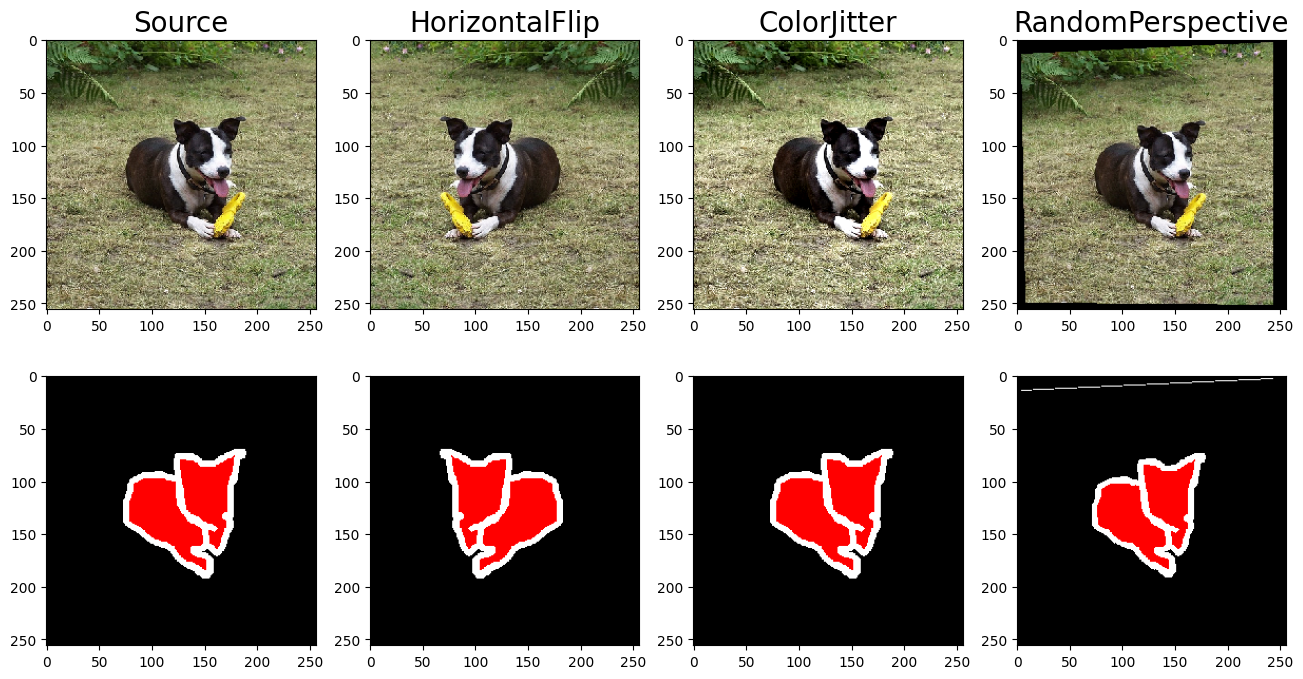

In [18]:
img_idx = np.random.randint(0, 100)
f, ax = plt.subplots(2, 4, figsize=(16, 8))
pair = train_data_hdf5[img_idx]

imgs2draw = {"Source": pair,
            "HorizontalFlip": HorizontalFlip(1.0)(pair),
            "ColorJitter": ColorJitter(1.0, (0.4, 0.4, 0.4))(pair),
            "RandomPerspective": RandomPerspective(1.0, 0.25)(pair)
}
for idx, (name, pair) in enumerate(imgs2draw.items()):
    ax[0, idx].imshow(pair[0])
    ax[0, idx].set_title(name, fontsize=20)
    ax[1, idx].imshow(colorize(np.array(pair[1])))

plt.show()

Далее описываем наш класс `SegmentationData` и операции приведения изображений типа PIL.Image к pytorch тензорам с ImageNet `нормализацией`. ImageNet нормализация - это частный случай [Standard normalization](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html), в котором поканальное среднее (цветовые каналы red, green, blue) и поканальное среднеквадратическое отклонение вычислены на [огромной выборке изображений](https://en.wikipedia.org/wiki/ImageNet).

**Ответьте на вопрос:** `А для чего нужно применять нормализацию к изображениям?`

**Ваш ответ:** чтобы привести все объекты обучающей и тестовых выборок к одному конкретному распределению так как всегда полагаем что они - н.о.р.с.в.

In [19]:
# Определяем устройство для вычислений (!желательно GPU!)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# конфигурации для преобразования картинок в тензора и обратно (для визуализации и обучения)
t_dict = {
    "forward_input": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]),
    "backward_input": transforms.Compose([
        transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                     std=[1./0.229, 1./0.224, 1./0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                     std=[1.0, 1.0, 1.0]),
        transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
    ]),
    "forward_target": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.long().squeeze().to(DEVICE)),
    ]),
    "backward_target": transforms.Compose([
        transforms.Lambda(lambda x: x.cpu().numpy())
    ]),
    "augment": transforms.Compose([
        HorizontalFlip(0.5),
        ColorJitter(0.5, (0.4, 0.4, 0.4)),
        RandomPerspective(0.5, 0.25)
    ]),
}


class SegmentationDataset(Dataset):
    def __init__(self, dataset_raw: Type[storage_class], transforms: dict, train_flag: bool = True):
        """
        Наследуем весь функционал из `Dataset` для наших данных `dataset_raw`
        `transforms` содержит преобразования PIL.Image <-> torch.tensor и аугментации
        `train_flag` регулирует аугментацию данных (для тестовой выборки она не нужна)
        """
        super().__init__()
        self.dataset_raw = dataset_raw
        self.transforms = transforms
        self.train_flag = train_flag

    def __len__(self):
        return self.dataset_raw.dataset_size

    def __getitem__(self, idx: int) -> tuple[Image_t, Image_t]:
        input, target = self.dataset_raw[idx]

        if (self.train_flag):
            input, target = self.transforms["augment"]((input, target))

        return self.transforms["forward_input"](input), self.transforms["forward_target"](target)

In [20]:
from torch.utils.data import random_split

# Разделяем выборку на обучающую и валидационную
def split_train_val(train_data: Type[storage_class], train_portion: float = 0.8):
    """
    `train_data` предобработанные данные
    `train_portion` доля объектов, которая будет приходиться на обучающую выборку
    """
    trainval_dataset = SegmentationDataset(train_data, t_dict, train_flag=True)

    train_size = int(len(trainval_dataset) * train_portion)
    val_size = len(trainval_dataset) - train_size
    return random_split(trainval_dataset, [train_size, val_size])

train_dataset_hdf5, val_dataset_hdf5 = split_train_val(train_data_hdf5)
train_dataset_memmap, val_dataset_memmap = split_train_val(train_data_memmap)
train_dataset_raw, val_dataset_raw = split_train_val(train_data_raw)

Отрисуем случайное изображение (после применения случайных преобразований аугментации):

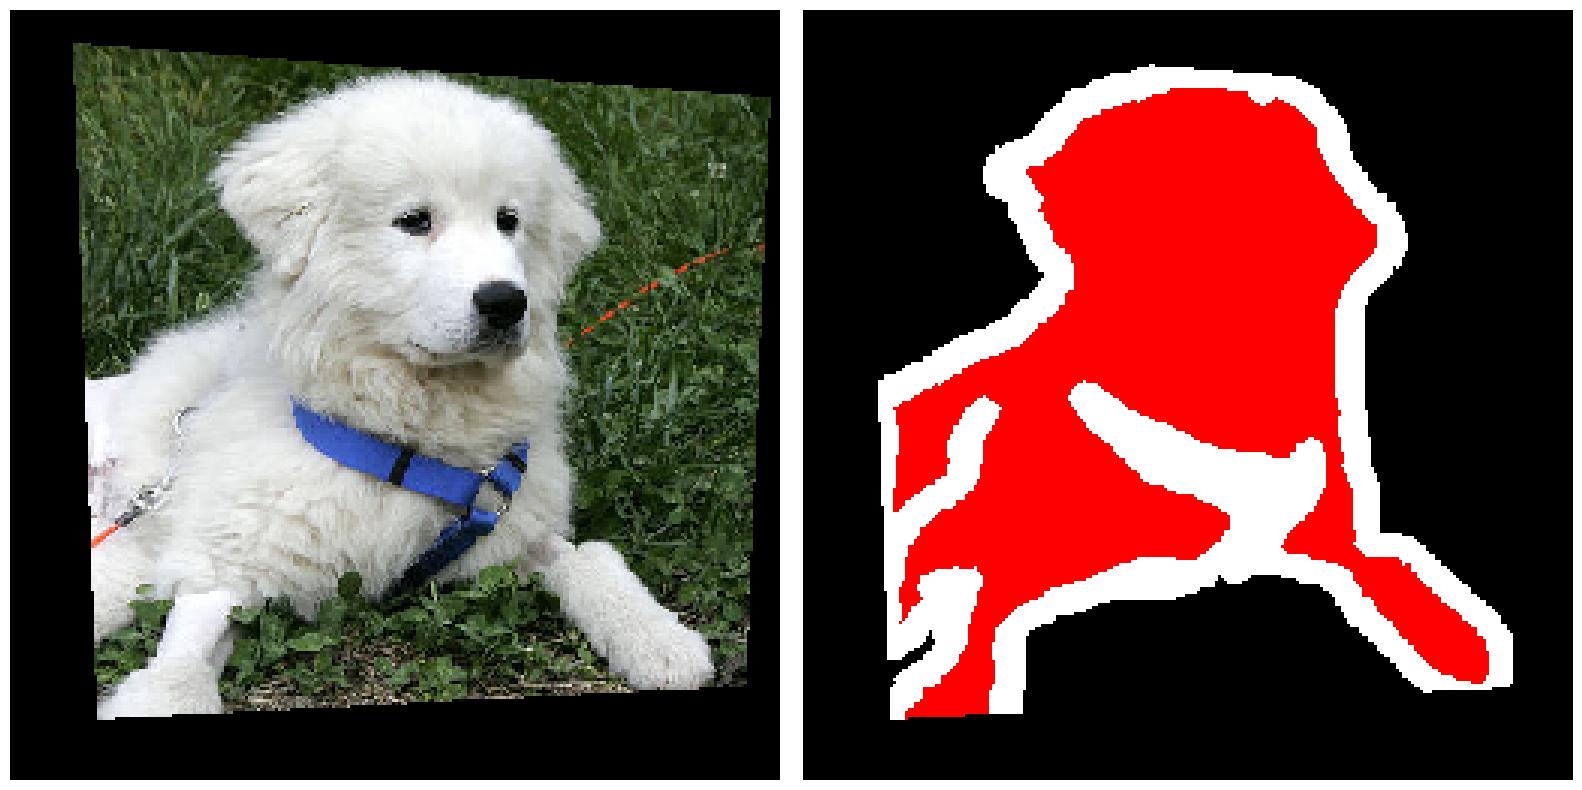

In [21]:
img_idx = np.random.randint(0, 100)
draw(train_dataset_hdf5[img_idx], t_dict);

In [22]:
dataloader_config = {
    "batch_size": 16,
    "shuffle": True,
    "num_workers": 0
}
train_dataloader_hdf5 = DataLoader(train_dataset_hdf5, **dataloader_config)
val_dataloader_hdf5 = DataLoader(val_dataset_hdf5, **dataloader_config)

train_dataloader_memmap = DataLoader(train_dataset_memmap, **dataloader_config)
val_dataloader_memmap = DataLoader(val_dataset_memmap, **dataloader_config)

train_dataloader_raw = DataLoader(train_dataset_raw, **dataloader_config)
val_dataloader_raw = DataLoader(val_dataset_raw, **dataloader_config)

### 1.3 Замер скорости чтения датасета с диска (3 балла)

**Замерьте время чтения нашего датасета для каждого из форматов хранения:** (Все SpeedTests вместе занимают около 6 минут!)

In [23]:
#def speedtest(dataloader: Type[DataLoader]) -> None:
#    for batch in dataloader:
#        pass

In [24]:
#%timeit speedtest(train_dataloader_hdf5)

In [25]:
#%timeit speedtest(train_dataloader_memmap)

In [26]:
#%timeit speedtest(train_dataloader_raw)

**Ответьте на вопрос: `Какой формат оказался самым эффективным по скорости? Почему?`**

**Ваш ответ:** самый быстрый - memmap потому что он работает как прямой доступ к данным в отличие от hdf5, где нужно распаковывать сжатые данные и разбирать  структуру файла, или raw, где каждый раз приходится открывать множество отдельных изображений

**Создайте тестовый Dataloader победившего по скорости формата.**

In [27]:
dataloader_config = {
    "batch_size": 16,
    "shuffle": False,
    "num_workers": 0
}
#YOUR CODE
test_data = prepare_dataset(config_test, storage_memmap)
test_dataset = SegmentationDataset(test_data, t_dict, train_flag=False)
# используйте: `config_test`, `prepare_dataset`, `SegmentationDataset`, новый `dataloader_config`
test_dataloader = DataLoader(test_dataset, **dataloader_config)

# добавьте новые переменные с выбранным форматом
train_dataloader = train_dataloader_memmap
val_dataloader = val_dataloader_memmap


  0%|          | 0/8 [00:00<?, ?it/s]

## Часть 2: Реализация функций потерь, метрик и декодировщика PSPNet

Ранее вас познакомили с архитектурой Unet - сверточными автокодировщиком, применяемом в области сегментации изображений. В данном задании мы разберем более продвинутую архитектуру сети сегментации [PSPNet](https://arxiv.org/abs/1612.01105). Отличительной особенностью этой сети является `Pyramid Pooling Module`, который, в отличие от Unet, позволяет учитывать `глобальный` контекст изображения при формировании признаков его `локальных` областей.

Рассмотрим предлагаемую архитектуру `PSPNet-подобной сети`:
![picture](https://drive.google.com/uc?id=1WNumWndaJAbZBch0dLf6iT8KiSdUbIFG)

В качестве кодировщика `Encoder` будем брать предобученную [ResNeXt](https://pytorch.org/hub/pytorch_vision_resnext/) сеть. Будем его использовать для получения двух глубинных представлений нашего входого изображения `x`:
- **выход `x_main`** (на рисунке: верхний выход Encoder-а ) - "среднее" промежуточное представление, компромисс между низкоуровневыми признаками (цвет, контуры объектов, штрихи) и высокоуровневыми признаками (абстрактные признаки, отражающие семантику изображения)
- **выход `x_supp`** (на рисунке: нижний выход Encoder-а ) - финальное представление, содержащее самые высокоуровневые признаки, в которых значительно утеряна информация о точном простанственном расположении объектов

Подобное разбиение выхода на 2 потока объясняется необходимостью в закодированной информации о пространственном расположении объектов (`x_main`) и вспомогательной информации о семантике всего изображения в целом (`x_supp`) для задачи семантической сегментации. Мы не можем себе позволить использовать лишь выход `x_supp`, как это делается, например, в задачах классификации, ведь от нас требуется дополнительное знание о расположении этого объекта на изображении.

**Ваша задача состоит в написании декодировщика `Decoder`, а именно в написании блоков:**
- **`Pyramid Pooling Module`**. Эта процедура необходима для извлечения глобального контекста разных масштабов, которого не хватает классическим сверточным нейронным сетям (локальный контекст в пределах размера фильтра).
    * К входному тензору `x_main` параллельно применяется несколько операций пулинга разных масштабов и получаются представления таких размеров: `1x1`, `2x2`, `3x3` и `6x6`.
    * Каналы этих промежуточных тензоров эффективно сжимаем (при помощи `nn.Conv2d c размером фильтра 1x1`). Делаем это для сжатия информации, а также для индивидуального взвешивания каждого тензора (назовем их тензорами глобального контекста разного масштаба).
    * Затем восстанавливаем полученные тензоры до исходных размеров с помощью интерполяции.
    * Выходной тензор получаем конкатенацией этих глобальных контекстов. Каждый контекст содержит информацию о всем изначальном изображении с разными уровнями детализации. Требуется реализовать `forward` этап этого блока. Для уточнения информации можно обратиться к [статье](https://arxiv.org/abs/1612.01105).
- **`Supplementary Module`** осуществляет нелинейное преобразование над входным тензором `x_supp` с понижением числа каналов до числа на выходе модуля **`Pyramid Pooling Module`**. Вариант архитектуры этого преобразования (композиции слоев) уже предложен, но, при желании, вы можете с ним экспериментировать
- **`Upsample Module`** осуществляет нелинейные преобразования над входным тензором с понижением числа каналов, которые чередуются с увеличением с помощью интерполяции пространственных размерностей в 2 раза. В результатае преобразований выход этого блока имеет ту же пространственную размерность, что и входное в кодировщик изображение.
- **`Segmentation Head`** нелинейно преобразует входной тензор в тензор score'ов. Выходной тензор для каждого пикселя имеет `num_classes` score'ов (в нашем случае 3). Индекс максимального score'а для заданного пикселя есть его метка класса (0, 1 или 2).

### 2.1 Кодировщик и декодировщик PSPNet-подобной сети (15 баллов)

In [28]:
from torchvision.models.resnet import ResNet

pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

# Выставляем evaluation mode (влияет на поведение таких слоев как BatchNorm2d, Dropout)
pretrained_model.eval();

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


100%|██████████| 95.8M/95.8M [00:00<00:00, 177MB/s]


Так как кодировщик используется предобученный, то требуется зафиксировать (заморозить) веса, чтобы по ним не тек градиент. Этим мы гарантируем, что кодировщик не изменяется в ходе обучения автокодировщика, а также экономим вычислительные ресурсы (граф градиента кодировщика не строится).

In [29]:
class EncoderBlock(nn.Module):
    def __init__(self, pretrained_model: Type[ResNet]):
        """
        Извлекает предобученные именованные слои кодировщика `pretrained_model`
        Разделяет слои на `main` и `supp` потоки (см. архитектуру выше)

        Вход: тензор (Batch_size, 3, Height, Width)

        Выход: x_main тензор (Batch_size, 512, Height // 8, Width // 8)
        Выход: x_supp тензор (Batch_size, 2048, Height // 32, Width // 32)
        """
        super().__init__()

        self.encoder_main = nn.Sequential()
        for name, child in list(pretrained_model.named_children())[:-4]:
            print(f"Pretrained main module {name} is loaded")
            self.encoder_main.add_module(name, child)

        self.encoder_supp = nn.Sequential()
        for name, child in list(pretrained_model.named_children())[-4:-2]:
            print(f"Pretrained supp module {name} is loaded")
            self.encoder_supp.add_module(name, child)

    def freeze(self) -> None:
        """
        Замораживает веса кодировщика
        """
        for p in self.parameters():
            p.requires_grad = False
        self.eval()

    def unfreeze(self) -> None:
        """
        Размораживает веса кодировщика
        """
        for p in self.parameters():
            p.requires_grad = True
        self.train()

    def forward(self, x: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
        x_main = self.encoder_main(x)
        x_supp = self.encoder_supp(x_main)
        return x_main, x_supp

In [30]:
encoder = EncoderBlock(pretrained_model)

Pretrained main module conv1 is loaded
Pretrained main module bn1 is loaded
Pretrained main module relu is loaded
Pretrained main module maxpool is loaded
Pretrained main module layer1 is loaded
Pretrained main module layer2 is loaded
Pretrained supp module layer3 is loaded
Pretrained supp module layer4 is loaded


**Для оценки сложности модели нам понадобится функция подсчета числа ее параметров, для этого используйте метод [model.parameters()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters). Реализуйте ее ниже:**

In [31]:
def count_parameters(model: Type[nn.Module]) -> int:
    """
    Считает число весов в модели `model`, для которых требуется градиент
    * Используйте model.parameters() чтобы получить список параметров:
        https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters
    * Используйте requires_grad, для проверки, считается ли для данного параметра градиент:
        https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter
    """
    #YOUR CODE
    total_params = 0
    for par in model.parameters():
      if par.requires_grad:
        total_params += 1

    return total_params

In [32]:
encoder.unfreeze()

Убедимся, что метод `.freeze()` успешно замораживает веса:

In [33]:
print("Encoder #parameters before freeze():", count_parameters(encoder))
encoder.freeze()
print("Encoder #parameters after freeze():", count_parameters(encoder))

Encoder #parameters before freeze(): 159
Encoder #parameters after freeze(): 0


* **Реализуйте `PyramidPoolingModule`, `Upsample` и `SegmentationHead` (по 5 баллов)**

In [34]:
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bin_sizes: tuple[int, ...]):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)
        `bin_sizes` - пространственные размерности для каждой пулинг операции
        Пример: bin_sizes = (1, 2, 3, 6).

        Выход: тензор (Batch_size, `in_channels` + len(`bin_sizes`) * `out_channels`, Height, Width)
        """
        super().__init__()
        self.bins = []

        for bin_size in bin_sizes:
            self.bins.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin_size), # почитайте: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
                nn.Conv2d(in_channels, out_channels, kernel_size=1), # почитайте: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
                nn.BatchNorm2d(out_channels), # почитайте: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
                nn.ReLU(inplace=True)
            ))

        self.bins = nn.ModuleList(self.bins)

    def forward(self, x: torch.tensor) -> torch.tensor:
        h, w = x.shape[2:]
        out = [x,]
        """
        * Пройдитесь циклом по self.bins и примените исходное изображение отдельно
          к каждому  блоку операций Pooling + Conv + BatchNorm + ReLU
        * После применения не забудьте на каждый выход сделать `Upscale`
          (используйте torch.functional.interpolate)
          и добавить результат в список `out`
        * Сконкатенируйте тензоры из out в один большой тензор по размерности с каналами
          с помощью torch.cat
        """
        #YOUR CODE
        res = [x,]
        for bin in self.bins:
          new = bin(x)
          new = F.interpolate(new, size=(h, w), mode='bilinear')
          res.append(new)
        return torch.cat(res, dim=1)


class SupplementaryModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout: float):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)

        Выход: тензор (Batch_size, `out_channels`, Height, Width)
        """
        super().__init__()
        self.suppl = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(in_channels // 2, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.suppl(x)


class Upsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)

        Выход: тензор (Batch_size, `out_channels`, 2 * Height, 2 * Width)
        """
        super().__init__()

        # Рекомендуем попробовать Conv2d (kernel: 3x3, padding=1) + BatchNorm2d + ReLU
        # YOUR CODE
        self.us_transform = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Увеличьте входное изображение в два раза, а затем примените us_transform
        Используйте torch.functional.interpolate c mode='bilinear', align_corners=True
        """
        # YOUR CODE
        new = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        return self.us_transform(new)


class UpsampleModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)

        Выход: тензор (Batch_size, `out_channels`, 8 * Height, 8 * Width)
        """
        super().__init__()
        self.upsample = nn.Sequential(
            Upsample(in_channels, in_channels // 4),
            Upsample(in_channels // 4, in_channels // 8),
            Upsample(in_channels // 8, out_channels)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.upsample(x)

In [35]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bin_sizes: tuple[int, ...], dropout: float = 0.1):
        """
        Вход  x_main: тензор (Batch_size, `in_channels`, Height, Width)
        Вход  x_supp: тензор (Batch_size, 4 * `in_channels`, Height // 4, Width // 4)

        Выход: тензор (Batch_size, `out_channels`, 8 * Height, 8 * Width)
        """
        super().__init__()
        assert in_channels % len(bin_sizes) == 0

        self.PPM = PyramidPoolingModule(in_channels, in_channels // len(bin_sizes), bin_sizes)
        self.SM = SupplementaryModule(4 * in_channels, 2 * in_channels, dropout)
        self.UM = UpsampleModule(4 * in_channels, out_channels)

    def forward(self, x_main: torch.tensor, x_supp: torch.tensor) -> torch.tensor:
        h_supp, w_supp = x_supp.shape[2:]
        x_supp = F.interpolate(input=x_supp, size=(4 * h_supp, 4 * w_supp), mode='bilinear', align_corners=True)

        x_supp = self.SM(x_supp)
        x_main = self.PPM(x_main)

        out = self.UM(torch.cat([x_main, x_supp], dim=1))
        return out


class SegmentationHead(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, dropout: float = 0.1):
        """
        Вычисляет score для каждого из классов
        Вход: тензор (Batch_size, `in_channels`, Height, Width)

        Выход: тензор (Batch_size, `num_classes`, Height, Width)
        """
        super().__init__()
        # Рекомендуем попробовать: BatchNorm2d + ReLU + Dropout2d + Conv2d (1 x 1)
        # YOUR CODE
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels//2),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.Conv2d(in_channels//2, num_classes, kernel_size=1)
        )

    def forward(self, x: torch.tensor, x_supp: torch.tensor) -> torch.tensor:
        """
        На будущее зададим фиктивный аргумент `x_supp`, который пока не будем использовать
        """
        return self.segmentation_head(x)

### 2.2 Реализация метрик (10 баллов)

В задаче сегментации для оценки предсказательной способности нейронной сети, в основном, используют следующие метрики:

Пусть $\mathrm{P}$ обозначает прогноз сег. маски (Prediction), $\mathrm{S}$ обозначает score'ы для каждого класса сег. маски (Scores), а $\mathrm{T}$ означает сег. маску (Target). Тогда:
- **Intersection over Union metric (коэффициент Жаккара)**:
$$
\mathrm{IoU}(P, T) = \dfrac{\sum_{i=1}^{M}\sum_{j=1}^{N}[P_{ij}*T_{ij}]}{\sum_{i=1}^{M}\sum_{j=1}^{N} [P_{ij} + T_{ij} - P_{ij}*T_{ij}]}\text{, где } P, T \in \{0, 1\}^{M \times N}
$$
- **Recall metric (полнота)**:
$$
\mathrm{Recall}(P, T) = \dfrac{\sum_{i=1}^{M}\sum_{j=1}^{N}[P_{ij} * T_{ij}]}{\sum_{i=1}^{M}\sum_{j=1}^{N} T_{ij}}\text{, где } P, T \in \{0, 1\}^{M \times N}
$$
Указанные выше метрики расписаны для случая бинарной сегментации, которая нам не подходит. Обобщим их на случай мультиклассовой сегментации: представим K-классовую задачу как K двухклассовых, а затем `макро-` или `микро-`усредним для них метрики. **Требуется реализовать мультиклассовые варианты указанных метрик с поддержкой макро- и микро-усреднения (по 3 балла). Обратите внимание, что метрики рассчитываются для каждого элемента из батча. За редуцирование метрик вдоль размерности батча отвечает аргумент `reduce` (см. ниже).**

Также для обучения будем использовать две разные, но схожие функции потерь:
- Cross Entropy Loss (кросс-энтропия):
$$
\mathrm{CE}(S, T) = - \dfrac{1}{MN}\sum_{c=1}^{K}\sum_{i=1}^{M}\sum_{j=1}^{N} \big[\log \mathrm{Softmax}(S)_{cij}*\mathbb{I}[T_{ij} == c]\big]\text{, где } S \in \mathbb{R}^{K \times M \times N}, T \in \{1, ..., K\}^{M \times N}
$$
- [Focal Loss](https://arxiv.org/abs/1708.02002):
$$
\mathrm{FL}(S, T) = - \dfrac{1}{MN}\sum_{c=1}^{K}\sum_{i=1}^{M}\sum_{j=1}^{N} \big[(1 - \mathrm{Softmax}(S)_{cij})^{\gamma}*\log \mathrm{Softmax}(S)_{cij}*\mathbb{I}[T_{ij} == c]\big]\text{, где } S \in \mathbb{R}^{K \times M \times N}, T \in \{1, ..., K\}^{M \times N}, \gamma \in \mathbb{R}_{+} - \text{гиперпараметр}
$$

**Функции потерь реализовывать не требуется**. Также всюду необходимо обеспечить корректную обработку значений `ignore_index`, которые в нашем случае равны 255 (не участвуют в расчете метрик/функций потерь). Если представители некоторых классов в $\mathrm{T}$ отсутствуют, то учитывать эти классы при макро-усреднении не нужно.

In [36]:
class MetricsCollection():
    def __init__(self, num_classes: int, ignore_index: int = 255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index

    def IoUMetric(self, prediction: torch.tensor, target: torch.tensor, average: str = "macro", reduce: str = "mean") -> Union[torch.tensor, float]:
        """
        `prediction` предсказанная сегментационная маска размера (Batch_size, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `average` тип мультклассового усреднения
        `reduce` редукция значений метрики вдоль размерности Batch; None - без редукции
        """

        """
        micro - суммируем знаменатель для всех классов, числитель для всех классов
                и делим одно на другое
        macro - считаем метрику по каждому классу отдельно, затем усредняем
        """
        assert average in ["micro", "macro"]

        """
        sum - сумма метрик по всем картинкам
        mean - среднее метрик по всем картинкам
        none - массив метрик по всем картинкам
        """
        assert reduce in ["sum", "mean", "none"]
        # Your Code
        batch_size = prediction.shape[0]
        ious = []

        for i in range(batch_size):
            pred = prediction[i]
            targ = target[i]

            ignore_mask = (targ == self.ignore_index)
            pred_filtered = pred[~ignore_mask]
            targ_filtered = targ[~ignore_mask]

            if len(pred_filtered) == 0:
                ious.append(torch.tensor(1.0))
                continue

            if average == 'micro':
                total_inter = 0
                total_union = 0

                for clas in range(self.num_classes):
                    pred_mask = (pred_filtered == clas)
                    targ_mask = (targ_filtered == clas)

                    inter = (pred_mask & targ_mask).sum().float()
                    union = (pred_mask | targ_mask).sum().float()

                    total_inter += inter
                    total_union += union

                if total_union > 0:
                    ious.append(total_inter / total_union)
                else:
                    ious.append(torch.tensor(1.0))

            else:
                class_iou = []
                for clas in range(self.num_classes):
                    pred_mask = (pred_filtered == clas)
                    targ_mask = (targ_filtered == clas)

                    inter = (pred_mask & targ_mask).sum().float()
                    union = (pred_mask | targ_mask).sum().float()

                    if union > 0:
                        class_iou.append(inter / union)

                if len(class_iou) > 0:
                    ious.append(torch.mean(torch.stack(class_iou)))
                else:
                    ious.append(torch.tensor(1.0))

        ious = torch.stack(ious) if ious else torch.tensor([1.0])

        if reduce == 'sum':
            return ious.sum()
        elif reduce == 'mean':
            return ious.mean()
        else:
            return ious
    def RecallMetric(self, prediction: torch.tensor, target: torch.tensor, average: str = "macro", reduce: str = "mean") -> Union[torch.tensor, float]:
        """
        `prediction` предсказанная сегментационная маска размера (Batch_size, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `average` тип мультклассового усреднения
        `reduce` редукция значений метрики вдоль размерности Batch; None - без редукции
        micro - суммируем знаменатель для всех классов, числитель для всех классов
                и делим одно на другое
        macro - считаем метрику по каждому классу отдельно, затем усредняем
        """
        assert average in ["micro", "macro"]
        """
        sum - сумма метрик по всем картинкам
        mean - среднее метрик по всем картинкам
        none - массив метрик по всем картинкам
        """
        assert reduce in ["sum", "mean", "none"]
        # Your Code

        batch_size = prediction.shape[0]
        recalls = []

        for i in range(batch_size):
            pred = prediction[i]
            targ = target[i]

            ignore_mask = (targ == self.ignore_index)
            pred_filtered = pred[~ignore_mask]
            targ_filtered = targ[~ignore_mask]

            if len(pred_filtered) == 0:
                recalls.append(torch.tensor(1.0))
                continue

            if average == 'micro':
                correct = (pred_filtered == targ_filtered).sum().float()
                total = len(pred_filtered)
                recall = correct / total if total > 0 else torch.tensor(1.0)
                recalls.append(recall)

            else:
                class_recall = []
                for clas in range(self.num_classes):
                    tp = ((pred_filtered == clas) & (targ_filtered == clas)).sum().float()
                    ap = (targ_filtered == clas).sum().float()

                    if ap > 0:
                        class_recall.append(tp / ap)
                if len(class_recall) > 0:
                    recalls.append(torch.mean(torch.stack(class_recall)))
                else:
                    recalls.append(torch.tensor(1.0))

        recalls = torch.stack(recalls) if recalls else torch.tensor([1.0])

        if reduce == 'sum':
            return recalls.sum()
        elif reduce == 'mean':
            return recalls.mean()
        else:
            return recalls

    def FocalLoss(self, scores: torch.tensor, target: torch.tensor, reduce: str = "mean", gamma: float = 1.) -> Union[torch.tensor, float]:
        """
        `scores` score'ы каждого класса сегментационной маски размера (Batch_size, num_classes, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `reduce` редукция значений функции потерь вдоль размерности Batch; None - без редукции
        """
        assert scores.shape[1] == self.num_classes
        assert reduce in ["sum", "mean", "none"]

        ce_loss = F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="none")
        coef = (1 - torch.exp(-ce_loss))**gamma
        focal_loss = coef * ce_loss
        norm = (focal_loss.numel() - (target == self.ignore_index).sum())

        if (reduce == "sum"):
            return focal_loss.sum() / norm * scores.shape[0]
        elif (reduce == "mean"):
            return focal_loss.sum() / norm
        else:
            return focal_loss.sum(dim=[1, 2]) / norm * scores.shape[0]

    def CrossEntropyLoss(self, scores: torch.tensor, target: torch.tensor, reduce: str = "mean") -> Union[torch.tensor, float]:
        """
        `scores` score'ы каждого класса сегментационной маски размера (Batch_size, num_classes, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `reduce` редукция значений функции потерь вдоль размерности Batch; None - без редукции
        """
        assert scores.shape[1] == self.num_classes
        assert reduce in ["sum", "mean", "none"]

        if (reduce == "sum"):
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="mean") * scores.shape[0]
        elif (reduce == "mean"):
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="mean")
        else:
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="none")

    @classmethod
    def ListMetrics(cls):
        return [method for method in dir(cls) if (method.endswith("Metric"))]

    @classmethod
    def ListLosses(cls):
        return [method for method in dir(cls) if (method.endswith("Loss"))]

In [37]:
metric_class = MetricsCollection(num_classes=3, ignore_index=255)

prediction = torch.tensor([[[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 1, 0], [0, 0, 0, 0]],
                           [[0, 0, 0, 0], [0, 2, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]]])

target = torch.tensor([[[0, 0, 0, 0], [0, 1, 255, 0], [0, 1, 255, 0], [0, 0, 0, 0]],
                       [[0, 0, 0, 0], [0, 255, 2, 0], [0, 255, 2, 0], [0, 0, 0, 0]]])
assert np.isclose(metric_class.IoUMetric(prediction, target, "micro", "mean").item(), 0.8667, atol=1e-3)
assert np.isclose(metric_class.IoUMetric(prediction, target, "macro", "mean").item(), 0.7115, atol=1e-3)
assert np.isclose(metric_class.RecallMetric(prediction, target, "micro", "mean").item(), 0.9286, atol=1e-3)
assert np.isclose(metric_class.RecallMetric(prediction, target, "macro", "mean").item(), 0.7500, atol=1e-3)


**Ответьте на вопрос (№1):** `Что говорит о предсказательной способности нашей сети ситуация: высокий Recall и низкий IoU для некоторого класса? Возможна ли обратная ситуация?`

**Ваш ответ:** в данном случае мы очень большую область относим к этому классу, поэтому он весь покрывается, но вместе м ним покрывается много лишнего. Обратная ситуация возможна, когда, например, выбранный класс мало представлен и его плохо выделяет наша модель и часто пропускает

**Ответьте на вопрос (№2):** `Какой вид усреднения правильней использовать в нашей задаче: макро и микро? Почему?`

**Ваш ответ:** макро усреднение обычно лучше в случае несбалансированных классов, поэтому для нашей задачи подойдет макро

**Ответьте на вопрос (№3):** `В чем преимущество Focal Loss перед Cross Entropy Loss? Что контроллирует гиперпараметр 𝛾 в Focal Loss?`

**Ваш ответ:** он учитывает дисбаланс классов, гиперпараметр контролирует насколько учитывать легкие примеры(доминирующие классы)

## Часть 3: Обучение PSPNet, эксперименты

Теперь **осталось лишь собрать все написанное ранее воедино и обучить нашу сеть**. Чтобы контроллировать процесс обучения нашей сети, будем вычислять усредненные метрики и функции потерь на валидационной выборке. Для удобства отображения информации **воспользуемся инструментом `tensorboard`**. Для этого заведем объект класса `SummaryWriter`, который создаст и откроет на запись специальный `event` файл для [tensorboard](https://pytorch.org/docs/stable/tensorboard.html). Для визуализации содержимого вводится команда `tensorboard --logdir=<PATH>` в терминале. Если возникла необходимость в мониториге нескольких tensorboard, то каждому из них требуется присвоить свой уникальный порт `--port <PORT>`. [Пример](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensorboard_with_pytorch.ipynb#scrollTo=lFKETpE2F2oE) использования tensorboard на Google Colab.

**Требуется написать методы `train_model` и `test_model`. Вся конфигурация обучения хранится в словаре `train_config`. При желании его можно дополнить чем-то своим.**

**К вашему решению потребуется прикрепить логи tensorboard. Чтобы облегчить процедуру проверки настоятельно рекомендуется пользоваться `inline-tensorboard`:**
```
%load_ext tensorboard
%tensorboard --logdir ./runs
```

### 3.1 Реализация процедур обучения/тестирования сети (6 баллов)

In [38]:
class PSPNet(nn.Module):
    def __init__(self, pretrained_model: Type[ResNet], HeadBlock: Type[nn.Module], num_classes: int, train_config: dict, bin_sizes: tuple[int, ...] = (1, 2, 3, 6)):
        """
        `pretrained_model` модель предобученного кодировщика
        `Head` класс блока, оценивающего score'ы для каждого класса сегментационной маски
        `num_class` число классов сегментации
        `train_config` словарь с конфигурацией процесса обучения сети
        `bin_sizes` пространственные размеры к которым сводит пулинг в блоке PPM
        """
        super().__init__()
        self.encoder = EncoderBlock(pretrained_model)
        self.encoder.freeze()
        self.decoder = DecoderBlock(512, 128, bin_sizes)
        self.head = HeadBlock(128, num_classes)

        self.train_config = train_config
        self.metric_class = train_config["metric_class"]
        self.optimizer = train_config["optimizer"](self.parameters(), **train_config["optimizer_params"])
        self.scheduler = train_config["scheduler"](self.optimizer, **train_config["scheduler_params"])
        self.criterion = train_config["loss_fn"]

    def forward(self, x: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
        # Для гарантии отсутствия градиентов по кодировщику
        with torch.no_grad():
            x_main, x_supp = self.encoder(x)
        out = self.decoder(x_main, x_supp)
        out = self.head(out, x_supp)
        return out, torch.argmax(out.detach(), dim=1)

    def write_val_metrics(self, val_metrics: dict, iter_num: int, norm: float = 1.0) -> None:
        """
        Записывает усредненные значения метрик/функций потерь в tensorboard

        `val_metrics` словарь с ключами "название_метрики/функции потерь" и их значениями
        `iter_num` номер глобальной итерации (по формуле #всего_итераций * номер_эпохи + номер_итерации)
        `norm` фактор нормализации; для усреднения равен числу объектов в валидационной выборке
        """
        for method, value in val_metrics.items():
            self.train_config["writer"].add_scalar(f"Mean {method}", np.round(val_metrics[method].item()/norm, 2), iter_num)

    def validate_model(self, val_dataloader: Type[DataLoader], iter_num: int) -> None:
        """
        Валидирует текущую модель и вычисляет соответствующие метрики/функции потерь

        `val_dataloader` валидационная выборка
        `iter_num` номер глобальной итерации (по формуле #всего_итераций * номер_эпохи + номер_итерации)
        """
        # Выставляет декодировщик в режим валидации (влияет на поведение BatchNorm2d и Dropout)
        self.decoder.eval()
        self.head.eval()

        # Инициализация словаря метрик/функций потерь
        val_metrics = dict([(method, 0.0) for method in (self.metric_class.ListMetrics() + self.metric_class.ListLosses())])

        # Обязательно считать с контекстным менеджером torch.no_grad()
        # Даже если мы не делаем шаг оптимизации, мы экономим память (не считаем градиенты)
        with torch.no_grad():
            for input, target in val_dataloader:
                scores, prediction = self.forward(input)
                for metric in self.metric_class.ListMetrics():
                    val_metrics[metric] += getattr(self.metric_class, metric)(prediction, target, reduce="sum")

                for loss in self.metric_class.ListLosses():
                    val_metrics[loss] += getattr(self.metric_class, loss)(scores, target, reduce="sum")

        # Tensorboard также позволяет сохранять визуализацию наших предсказаний в ходе обучения
        figure = draw((input[0], target[0]), t_dict, prediction[0], log=True)
        self.train_config["writer"].add_figure("image/GT/prediction", figure, iter_num)

        self.write_val_metrics(val_metrics, iter_num, norm=len(val_dataloader.dataset))
        # Возвращает режим обучения декодировщика
        self.decoder.train()

    def train_model(self, train_dataloader: Type[DataLoader], val_dataloader: Type[DataLoader]) -> None:
        """
        Обучает модель на обучающей выборке, периодически (периодичность выставляется в train_config) валидирует на валидационной выборке
        В конце каждой эпохи сохраняет модель на диск

        `train_dataloader` обучающая выборка
        `val_dataloader` валидационная выборка
        """
        # Выставляет режим обучения декодировщика
        self.decoder.train()
        self.head.train()

        for epoch in range(self.train_config["num_epochs"]):
            for iter_num, (input, target) in enumerate(train_dataloader):
                self.optimizer.zero_grad()
                # YOUR CODE

                score, prediction = self.forward(input)
                loss = self.criterion(score, target)
                loss.backward()
                self.optimizer.step()

                if (iter_num % self.train_config["validate_each_iter"] == 0):
                    print(f"Epoch: {epoch+1}/{self.train_config['num_epochs']} || Iter: {iter_num}/{len(train_dataloader)} || Loss: {loss.item()}")
                    self.validate_model(val_dataloader, epoch * len(train_dataloader) + iter_num)

            torch.save(self.state_dict(), self.train_config["save_model_path"] + f"_{epoch+1}.pth")
            self.scheduler.step()

    def test_model(self, test_dataloader: Type[DataLoader]) -> tuple[torch.tensor, torch.tensor]:
        """
        Inference модели на тестовой выборке. Возвращает тензор предсказаний сег.масок и тензор истинных сег.масок

        `test_dataloader` тестовая выборка
        """
        # Выставляет декодировщик в режим валидации (влияет на поведение BatchNorm2d и Dropout)
        self.decoder.eval()
        # YOUR CODE

        dl_prediction = torch.empty(size=(1, 256, 256)).cuda()
        dl_target = torch.empty(size=(1, 256, 256)).cuda()

        with torch.no_grad():
          for iter_num, (input, target) in enumerate(test_dataloader):
            input = input.cuda()
            target = target.cuda()
            scores, prediction = self.forward(input)
            dl_prediction = torch.cat([dl_prediction, prediction], dim = 0)
            dl_target = torch.cat([dl_target, target], dim=0)

        return dl_prediction, dl_target

### 3.2 Обучение PSPNet, эксперименты (15 баллов)

Вам приведены начальные значения гиперпараметров сети. Подберите гиперпараметры (если необходимо) и обучите сеть на обе функции потерь `CrossEntropyLoss` и `FocalLoss`. Добейтесь следующих результатов на тестовой выборке хотя бы для одной из них:
- **`Mean IoU metric` > 0.82**
- **`Mean Recall metric` > 0.92**

К вашему решению требуется прикрепить логи tensorboard.

**CrossEntropyLoss**

In [39]:
from torch.optim.lr_scheduler import StepLR

train_config = {
    "num_epochs": 2, # примерное время обучения ~ 20 минут на GPU
    "optimizer": torch.optim.Adam,
    "optimizer_params": {
        "lr": 1e-3,
        "weight_decay": 1e-5
    },
    "loss_fn": metric_class.CrossEntropyLoss,
    "scheduler": StepLR,
    "scheduler_params": {
        "step_size": 50,
        "gamma": 0.85
    },
    "validate_each_iter": 10,
    "writer": SummaryWriter(comment="CEloss"),
    "save_model_path": "model_celoss",
    "metric_class": metric_class
}

net = PSPNet(pretrained_model, SegmentationHead, num_classes=3, train_config=train_config).to(DEVICE)
print("#параметров в сети:", count_parameters(net))

Pretrained main module conv1 is loaded
Pretrained main module bn1 is loaded
Pretrained main module relu is loaded
Pretrained main module maxpool is loaded
Pretrained main module layer1 is loaded
Pretrained main module layer2 is loaded
Pretrained supp module layer3 is loaded
Pretrained supp module layer4 is loaded
#параметров в сети: 42


In [40]:
net.train_model(train_dataloader, val_dataloader)

Epoch: 1/2 || Iter: 0/184 || Loss: 1.5031620264053345
Epoch: 1/2 || Iter: 10/184 || Loss: 0.3889389932155609
Epoch: 1/2 || Iter: 20/184 || Loss: 0.3650886118412018
Epoch: 1/2 || Iter: 30/184 || Loss: 0.25057825446128845
Epoch: 1/2 || Iter: 40/184 || Loss: 0.3970130383968353
Epoch: 1/2 || Iter: 50/184 || Loss: 0.3994061350822449
Epoch: 1/2 || Iter: 60/184 || Loss: 0.20679037272930145
Epoch: 1/2 || Iter: 70/184 || Loss: 0.15689732134342194
Epoch: 1/2 || Iter: 80/184 || Loss: 0.1759248524904251
Epoch: 1/2 || Iter: 90/184 || Loss: 0.20174776017665863
Epoch: 1/2 || Iter: 100/184 || Loss: 0.14026878774166107
Epoch: 1/2 || Iter: 110/184 || Loss: 0.2185422033071518
Epoch: 1/2 || Iter: 120/184 || Loss: 0.15511378645896912
Epoch: 1/2 || Iter: 130/184 || Loss: 0.22632412612438202
Epoch: 1/2 || Iter: 140/184 || Loss: 0.16779939830303192
Epoch: 1/2 || Iter: 150/184 || Loss: 0.22087214887142181
Epoch: 1/2 || Iter: 160/184 || Loss: 0.1618044227361679
Epoch: 1/2 || Iter: 170/184 || Loss: 0.26614570617

In [41]:
# Протестируйте модель:
net.load_state_dict(torch.load("model_celoss_1.pth")) # Не забудьте поменять версию `_1`-> `_n` если запускаете несколько раз!
net.eval();
dl_prediction, dl_target = net.test_model(test_dataloader)
print("Mean IoU metric: ", metric_class.IoUMetric(dl_prediction, dl_target))
print("Mean Recall metric: ", metric_class.RecallMetric(dl_prediction, dl_target))

Mean IoU metric:  tensor(0.8303, device='cuda:0')
Mean Recall metric:  tensor(0.9442, device='cuda:0')


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

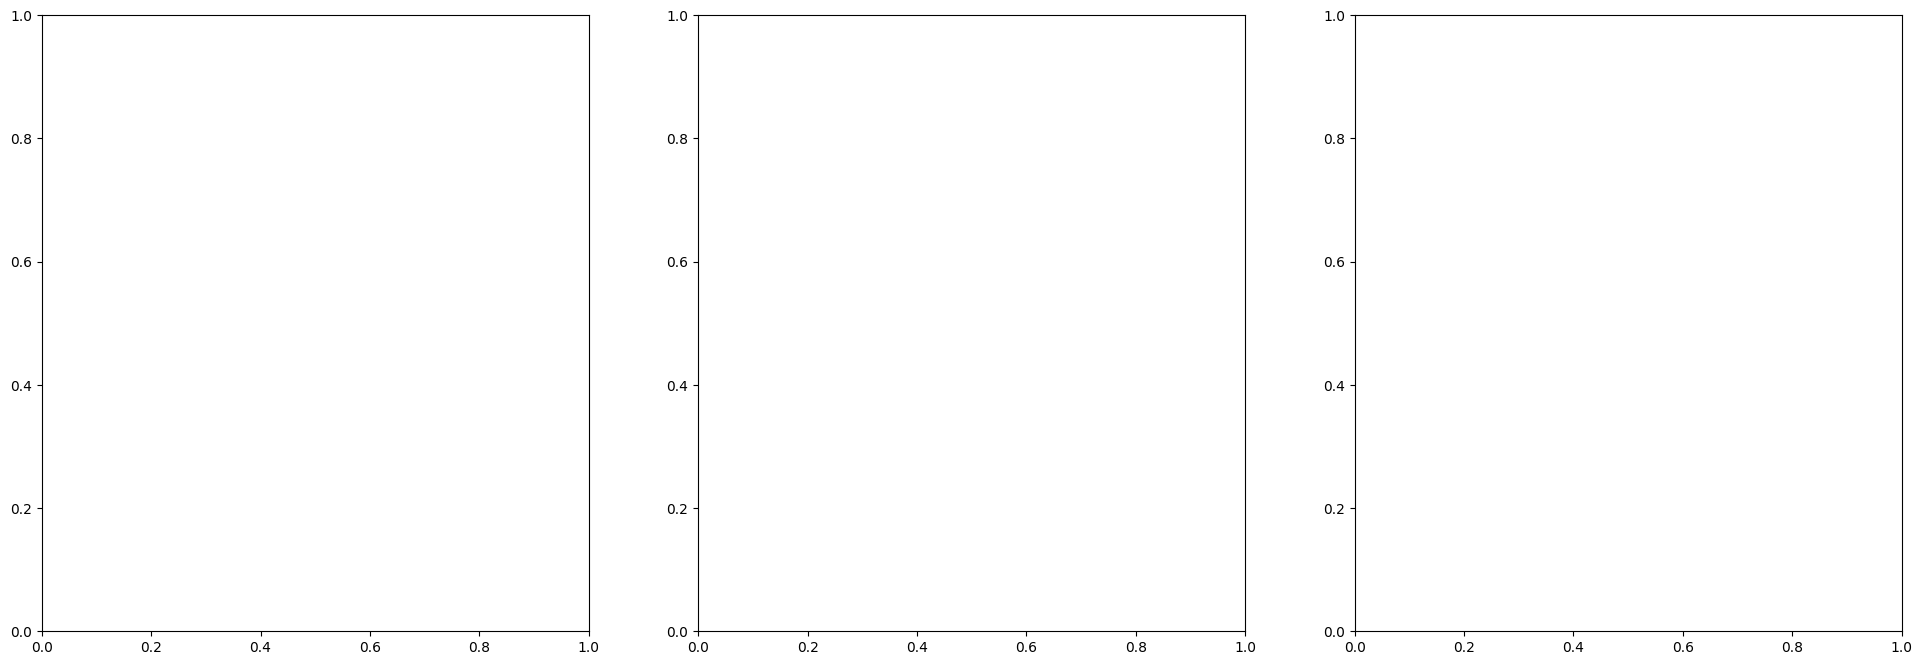

In [42]:
# Примеры работы вами сети:
img_idx = np.random.randint(0, 100)
for idx, (input, target) in enumerate(test_dataloader):
    if (idx < img_idx):
        continue
    draw((input.squeeze(), target.squeeze()), t_dict, dl_prediction[idx])
    plt.pause(0.1)
    if (idx == img_idx+2):
        break

**FocalLoss**

In [44]:
from torch.optim.lr_scheduler import StepLR

train_config = {
    "num_epochs": 2, # примерное время обучения ~ 20 минут на GPU
    "optimizer": torch.optim.Adam,
    "optimizer_params": {
        "lr": 1e-3,
        "weight_decay": 1e-5
    },
    "loss_fn": metric_class.FocalLoss,
    "scheduler": StepLR,
    "scheduler_params": {
        "step_size": 50,
        "gamma": 0.85
    },
    "validate_each_iter": 10,
    "writer": SummaryWriter(comment="Floss"),
    "save_model_path": "model_floss",
    "metric_class": metric_class
}

net_1 = PSPNet(pretrained_model, SegmentationHead, num_classes=3, train_config=train_config).to(DEVICE)
print("#параметров в сети:", count_parameters(net_1))

Pretrained main module conv1 is loaded
Pretrained main module bn1 is loaded
Pretrained main module relu is loaded
Pretrained main module maxpool is loaded
Pretrained main module layer1 is loaded
Pretrained main module layer2 is loaded
Pretrained supp module layer3 is loaded
Pretrained supp module layer4 is loaded
#параметров в сети: 42


In [45]:
net_1.train_model(train_dataloader, val_dataloader)

Epoch: 1/2 || Iter: 0/184 || Loss: 0.8803392052650452
Epoch: 1/2 || Iter: 10/184 || Loss: 0.1977275013923645
Epoch: 1/2 || Iter: 20/184 || Loss: 0.17610415816307068
Epoch: 1/2 || Iter: 30/184 || Loss: 0.14352703094482422
Epoch: 1/2 || Iter: 40/184 || Loss: 0.12096840143203735
Epoch: 1/2 || Iter: 50/184 || Loss: 0.26188424229621887
Epoch: 1/2 || Iter: 60/184 || Loss: 0.14193615317344666
Epoch: 1/2 || Iter: 70/184 || Loss: 0.08752532303333282
Epoch: 1/2 || Iter: 80/184 || Loss: 0.07628759741783142
Epoch: 1/2 || Iter: 90/184 || Loss: 0.11243478208780289
Epoch: 1/2 || Iter: 100/184 || Loss: 0.08033991605043411
Epoch: 1/2 || Iter: 110/184 || Loss: 0.09130571782588959
Epoch: 1/2 || Iter: 120/184 || Loss: 0.13281770050525665
Epoch: 1/2 || Iter: 130/184 || Loss: 0.107497438788414
Epoch: 1/2 || Iter: 140/184 || Loss: 0.1236700490117073
Epoch: 1/2 || Iter: 150/184 || Loss: 0.13819245994091034
Epoch: 1/2 || Iter: 160/184 || Loss: 0.1052282303571701
Epoch: 1/2 || Iter: 170/184 || Loss: 0.187037676

In [46]:
# Протестируйте вторую модель и сравните метрики:
net_1.load_state_dict(torch.load("model_floss_1.pth"))  # Не забудьте поменять версию `_1`-> `_n` если запускаете несколько раз!
net_1.eval();
dl_prediction, dl_target = net_1.test_model(test_dataloader)
print("Mean IoU metric: ", metric_class.IoUMetric(dl_prediction, dl_target))
print("Mean Recall metric: ", metric_class.RecallMetric(dl_prediction, dl_target))

Mean IoU metric:  tensor(0.8033, device='cuda:0')
Mean Recall metric:  tensor(0.9155, device='cuda:0')


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

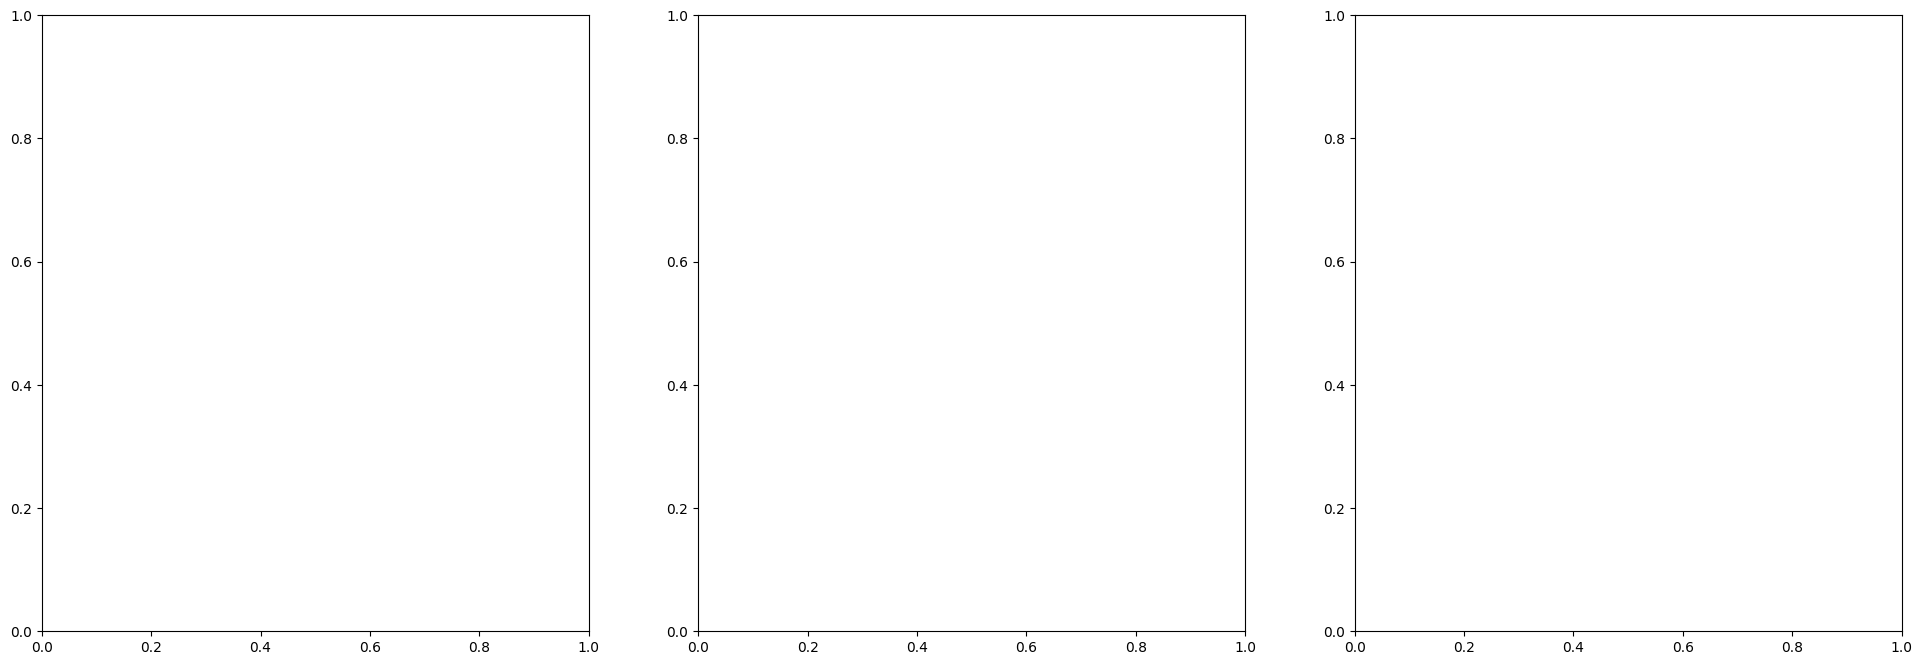

In [47]:
# Примеры работы вами сети:
img_idx = np.random.randint(0, 100)
for idx, (input, target) in enumerate(test_dataloader):
    if (idx < img_idx):
        continue
    draw((input.squeeze(), target.squeeze()), t_dict, dl_prediction[idx])
    plt.pause(0.1)
    if (idx == img_idx+2):
        break